In [13]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import xml.etree.ElementTree as ET
import cv2
import torch.nn.functional as F 

    
device = torch.device("mps")




# 实验参考步骤
1. 从 https://monuseg.grand-challenge.org/Data/ 下载数据，训练数据下载地址：“Training Data”段落下“The dataset (images and annotations) can be downloaded using the following links- MoNuSeg 2018 Training data”，测试数据下载地址“Testing Data”段落下“Test set images with additional 7000 nuclear boundary annotations are available here MoNuSeg 2018 Testing data. ”；数据集介绍https://ieeexplore.ieee.org/document/8880654
2. 将数据集拷贝到本文件同一目录下

# 加载训练数据集

all_files ['TCGA-G9-6348-01Z-00-DX1', 'TCGA-MH-A561-01Z-00-DX1', 'TCGA-E2-A1B5-01Z-00-DX1', 'TCGA-CH-5767-01Z-00-DX1', 'TCGA-AR-A1AS-01Z-00-DX1', 'TCGA-G9-6336-01Z-00-DX1', 'TCGA-DK-A2I6-01A-01-TS1', 'TCGA-HE-7130-01Z-00-DX1', 'TCGA-A7-A13F-01Z-00-DX1', 'TCGA-G9-6356-01Z-00-DX1', 'TCGA-HE-7128-01Z-00-DX1', 'TCGA-FG-A87N-01Z-00-DX1', 'TCGA-G2-A2EK-01A-02-TSB', 'TCGA-NH-A8F7-01A-01-TS1', 'TCGA-AY-A8YK-01A-01-TS1', 'TCGA-38-6178-01Z-00-DX1', 'TCGA-A7-A13E-01Z-00-DX1', 'TCGA-HE-7129-01Z-00-DX1', 'TCGA-G9-6363-01Z-00-DX1', 'TCGA-21-5786-01Z-00-DX1', 'TCGA-18-5592-01Z-00-DX1', 'TCGA-B0-5698-01Z-00-DX1', 'TCGA-XS-A8TJ-01Z-00-DX1', 'TCGA-KB-A93J-01A-01-TS1', 'TCGA-UZ-A9PJ-01Z-00-DX1', 'TCGA-BC-A217-01Z-00-DX1', 'TCGA-G9-6362-01Z-00-DX1', 'TCGA-AR-A1AK-01Z-00-DX1', 'TCGA-RD-A8N9-01A-01-TS1', 'TCGA-B0-5711-01Z-00-DX1', 'TCGA-50-5931-01Z-00-DX1', 'TCGA-F9-A8NY-01Z-00-DX1', 'TCGA-E2-A14V-01Z-00-DX1', 'TCGA-21-5784-01Z-00-DX1', 'TCGA-49-4488-01Z-00-DX1', 'TCGA-B0-5710-01Z-00-DX1', 'TCGA-UZ-A9PN-01Z

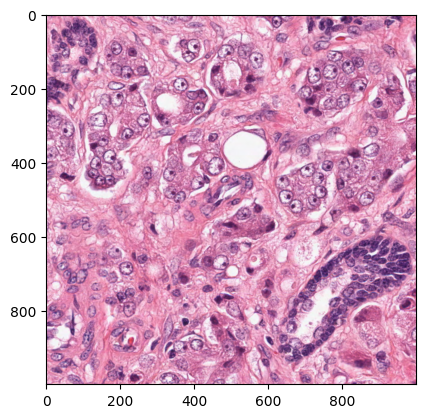

In [14]:
# 用这个方法可以找到所有的数据名称
folder_path = "./exercise3/MoNuSeg 2018 Training Data/Tissue Images"
all_files = os.listdir(folder_path)
all_files = [filename[:-4] for filename in all_files]
print("all_files", all_files)

x_train = []
for file in all_files:
    img = plt.imread("./exercise3/MoNuSeg 2018 Training Data/Tissue Images/"+file+".tif")
    x_train.append(img)

x_train = np.array(x_train, dtype=np.float32)/255. # 这个是之后要用的训练集细胞图像
print(x_train.shape)
plt.imshow(x_train[0,:,:,:])


In [15]:
# 一个用来把 xml 转化为图像的函数


def xml_to_mask(xml_path, image_shape):
    mask = np.zeros(image_shape, dtype=np.uint8)
    
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        for annotation in root.findall('Annotation'):
            for region in annotation.findall('Regions/Region'):
                vertices = []
                for vertex in region.findall('Vertices/Vertex'):
                    x = float(vertex.get('X'))
                    y = float(vertex.get('Y'))
                    vertices.append([x, y])
                
                if len(vertices) > 2:  # Need at least 3 points for a polygon
                    vertices = np.array(vertices, dtype=np.int32)
                    cv2.fillPoly(mask, [vertices], color=1)
                    
    except Exception as e:
        print(f"Error processing {xml_path}: {str(e)}")
    
    return mask

(37, 1000, 1000, 1)


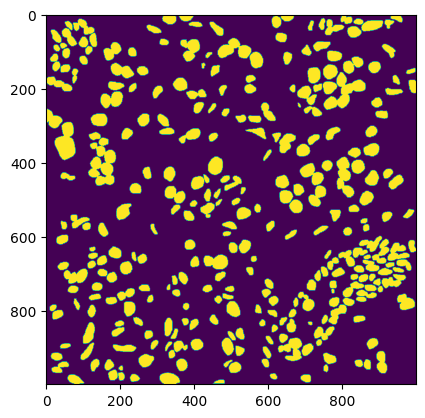

In [16]:
y_train = []
for file in all_files:
    mask = xml_to_mask("./exercise3/MoNuSeg 2018 Training Data/Annotations/"+file+".xml", (x_train.shape[1],x_train.shape[2],1))
    y_train.append(mask)
y_train = np.array(y_train, dtype=np.float32) # 这个是之后要用的训练集细胞图分割结果
print(y_train.shape)
plt.imshow(y_train[0,:,:])

(333, 256, 256, 3) (333, 256, 256, 1)


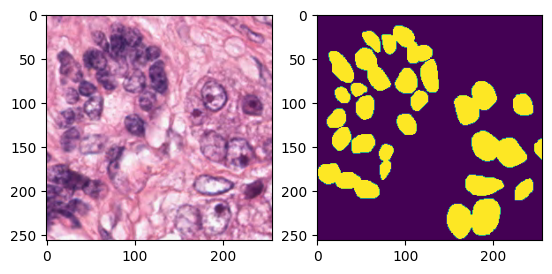

In [17]:
# 图像太大了，可以分成小块进行训练
x_train_patch = []
y_train_patch = []
for k in range(x_train.shape[0]):
    for i in range(3):
        for j in range(3):
            x_train_patch.append(x_train[k,i*256:(i+1)*256,j*256:(j+1)*256,:])
            y_train_patch.append(y_train[k,i*256:(i+1)*256,j*256:(j+1)*256,:])
x_train_patch = np.array(x_train_patch)
y_train_patch = np.array(y_train_patch)
print(x_train_patch.shape, y_train_patch.shape)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(x_train_patch[0,:,:,:])
plt.subplot(1,2,2)
plt.imshow(y_train_patch[0,:,:,:])

In [18]:
# 得到训练集的 dataloader

# Data loaders
Batch_size = 8

x_train_patch = np.transpose(x_train_patch, (0, 3, 1, 2))
y_train_patch = np.transpose(y_train_patch, (0, 3, 1, 2))
print(x_train_patch.shape, y_train_patch.shape)

train_dataset = TensorDataset(torch.tensor(x_train_patch), torch.tensor(y_train_patch))
train_loader = DataLoader(train_dataset, batch_size=Batch_size, shuffle=True)

(333, 3, 256, 256) (333, 1, 256, 256)


# 练习：加载测试数据集
请仿照上面的步骤，创建测试集的dataloader

all_test_files ['TCGA-IZ-8196-01A-01-BS1', 'TCGA-69-7764-01A-01-TS1', 'TCGA-HT-8564-01Z-00-DX1', 'TCGA-A6-6782-01A-01-BS1', 'TCGA-ZF-A9R5-01A-01-TS1', 'TCGA-44-2665-01B-06-BS6', 'TCGA-FG-A4MU-01B-01-TS1', 'TCGA-2Z-A9J9-01A-01-TS1', 'TCGA-GL-6846-01A-01-BS1', 'TCGA-HC-7209-01A-01-TS1', 'TCGA-EJ-A46H-01A-03-TSC', 'TCGA-AO-A0J2-01A-01-BSA', 'TCGA-CU-A0YN-01A-02-BSB', 'TCGA-AC-A2FO-01A-01-TS1']
(14, 1000, 1000, 3)


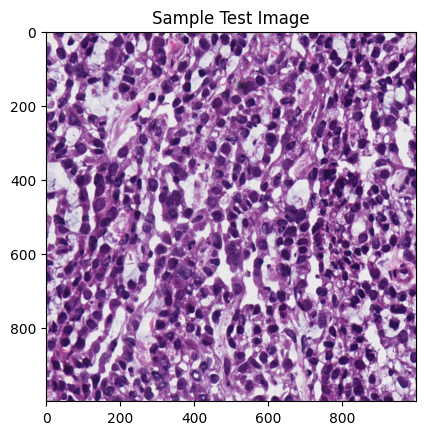

In [19]:
test_folder_path = "./exercise3/MoNuSegTestData/"
all_test_files = os.listdir(test_folder_path)
# 选择.tif文件
all_test_files = [filename[:-4] for filename in all_test_files if filename.endswith(".tif")]
print("all_test_files", all_test_files)

x_test = []
for file in all_test_files: 
    img = plt.imread(test_folder_path + file + ".tif") 
    x_test.append(img)

x_test = np.array(x_test, dtype=np.float32)/255. # 这个是之后要用的测试集细胞图像
print(x_test.shape)
if len(x_test) > 0:
    plt.figure() # 创建新的图像窗口
    plt.imshow(x_test[0,:,:,:])
    plt.title("Sample Test Image")

(14, 1000, 1000, 1)


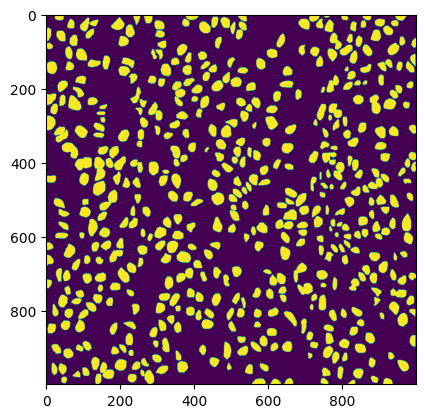

In [20]:
y_test = []
for file in all_test_files:
    mask = xml_to_mask("./exercise3/MoNuSegTestData/"+file+".xml", (x_test.shape[1],x_test.shape[2],1))
    y_test.append(mask)
y_test = np.array(y_test, dtype=np.float32) # 这个是之后要用的训练集细胞图分割结果
print(y_test.shape)
plt.imshow(y_test[0,:,:])

(126, 256, 256, 3) (126, 256, 256, 1)


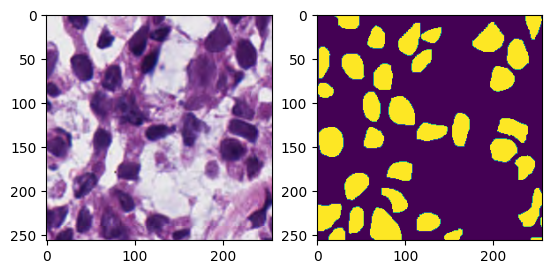

In [21]:
x_test_patch = []
y_test_patch = []
for k in range(x_test.shape[0]):
    for i in range(3):
        for j in range(3):
            x_test_patch.append(x_test[k,i*256:(i+1)*256,j*256:(j+1)*256,:])
            y_test_patch.append(y_test[k,i*256:(i+1)*256,j*256:(j+1)*256,:])
x_test_patch = np.array(x_test_patch)
y_test_patch = np.array(y_test_patch)
print(x_test_patch.shape, y_test_patch.shape)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(x_test_patch[0,:,:,:])
plt.subplot(1,2,2)
plt.imshow(y_test_patch[0,:,:,:])

In [22]:
# 得到训练集的 dataloader

# Data loaders
Batch_size = 8

x_test_patch = np.transpose(x_test_patch, (0, 3, 1, 2))
y_test_patch = np.transpose(y_test_patch, (0, 3, 1, 2))
print(x_test_patch.shape, y_test_patch.shape)

test_dataset = TensorDataset(torch.tensor(x_test_patch), torch.tensor(y_test_patch))
test_loader = DataLoader(test_dataset, batch_size=Batch_size, shuffle=True)

(126, 3, 256, 256) (126, 1, 256, 256)


在encoder和decoder每个卷积层后都加入归一化层

In [23]:
class Unet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        self.e11 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(32)
        self.e12 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e21 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(64)
        self.e22 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e31 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(128)
        self.e32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e41 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(256)
        self.e42 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e51 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn51 = nn.BatchNorm2d(512)
        self.e52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn52 = nn.BatchNorm2d(512)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        # After upconv, concatenation happens, then Conv2d. So BatchNorm for d11 will be after Conv2d(512, ...)
        self.d11 = nn.Conv2d(512, 256, kernel_size=3, padding=1) # Input channels: 256 (from upconv) + 256 (from xe42 skip connection)
        self.bn_d11 = nn.BatchNorm2d(256)
        self.d12 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn_d12 = nn.BatchNorm2d(256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(256, 128, kernel_size=3, padding=1) # Input channels: 128 (upconv) + 128 (xe32)
        self.bn_d21 = nn.BatchNorm2d(128)
        self.d22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn_d22 = nn.BatchNorm2d(128)

        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(128, 64, kernel_size=3, padding=1) # Input channels: 64 (upconv) + 64 (xe22)
        self.bn_d31 = nn.BatchNorm2d(64)
        self.d32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn_d32 = nn.BatchNorm2d(64)

        self.upconv4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(64, 32, kernel_size=3, padding=1) # Input channels: 32 (upconv) + 32 (xe12)
        self.bn_d41 = nn.BatchNorm2d(32)
        self.d42 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn_d42 = nn.BatchNorm2d(32)

        self.outconv = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = F.relu(self.bn11(self.e11(x)))
        xe12 = F.relu(self.bn12(self.e12(xe11)))
        xp1 = self.pool1(xe12)

        xe21 = F.relu(self.bn21(self.e21(xp1)))
        xe22 = F.relu(self.bn22(self.e22(xe21)))
        xp2 = self.pool2(xe22)

        xe31 = F.relu(self.bn31(self.e31(xp2)))
        xe32 = F.relu(self.bn32(self.e32(xe31)))
        xp3 = self.pool3(xe32)

        xe41 = F.relu(self.bn41(self.e41(xp3)))
        xe42 = F.relu(self.bn42(self.e42(xe41)))
        xp4 = self.pool4(xe42)

        xe51 = F.relu(self.bn51(self.e51(xp4)))
        xe52 = F.relu(self.bn52(self.e52(xe51)))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = F.relu(self.bn_d11(self.d11(xu11)))
        xd12 = F.relu(self.bn_d12(self.d12(xd11)))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = F.relu(self.bn_d21(self.d21(xu22)))
        xd22 = F.relu(self.bn_d22(self.d22(xd21)))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = F.relu(self.bn_d31(self.d31(xu33)))
        xd32 = F.relu(self.bn_d32(self.d32(xd31)))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = F.relu(self.bn_d41(self.d41(xu44)))
        xd42 = F.relu(self.bn_d42(self.d42(xd41)))

        out = self.outconv(xd42)

        return out

    


# 练习：完成模型训练部分的代码

In [24]:

model = Unet(n_class=1).to(device) 
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 10
train_losses, test_losses = [], []

x_train_tensor = torch.from_numpy(x_train_patch).float().to(device)
y_train_tensor = torch.from_numpy(y_train_patch).float().to(device)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=Batch_size, shuffle=True)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    model.eval()  # 设置为评估模式
    test_loss = 0.0
    with torch.no_grad():  # 不计算梯度
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
    epoch_test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(epoch_test_loss)


    torch.save(model, "./model.pt")

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")
    



Epoch 1/10, Train Loss: 0.5304, Test Loss: 0.4498
Epoch 2/10, Train Loss: 0.4298, Test Loss: 0.4240
Epoch 3/10, Train Loss: 0.3930, Test Loss: 0.3994
Epoch 4/10, Train Loss: 0.3710, Test Loss: 0.3515
Epoch 5/10, Train Loss: 0.3559, Test Loss: 0.4035
Epoch 6/10, Train Loss: 0.3428, Test Loss: 0.3434
Epoch 7/10, Train Loss: 0.3299, Test Loss: 0.3331
Epoch 8/10, Train Loss: 0.3163, Test Loss: 0.3167
Epoch 9/10, Train Loss: 0.3077, Test Loss: 0.3693
Epoch 10/10, Train Loss: 0.2975, Test Loss: 0.3208


电脑硬件有限，显存不足，故修改此部分，分批次进行计算（使用了ai）

In [25]:
model.eval()     

def iou(pred, target): 
    pred = pred > 0.5
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    
    iou = intersection.float() / union.float()
    return iou

ious_list = [] 

# 使用 torch.no_grad() 来禁用梯度计算，减少内存并加速
with torch.no_grad():
    num_samples = x_train_patch.shape[0]
    for i in range(0, num_samples, Batch_size):
        x_batch_np = x_train_patch[i : min(i + Batch_size, num_samples)]
        y_batch_np = y_train_patch[i : min(i + Batch_size, num_samples)]
        x_batch_tensor = torch.from_numpy(x_batch_np).float().to(device)
        batch_preds_logits = model(x_batch_tensor)
        targets_batch_tensor = torch.from_numpy(y_batch_np).float().to(device)

        
        preds_batch_probs = torch.sigmoid(batch_preds_logits) 
        for j in range(preds_batch_probs.shape[0]):
            pred_sample = preds_batch_probs[j]  
            target_sample = targets_batch_tensor[j] 

            iou_value = iou(pred_sample, target_sample)
            ious_list.append(iou_value.cpu().item()) 
ious = np.array(ious_list)
print(ious)
print(np.mean(ious))





[0.68493086 0.76016885 0.74705786 0.71642202 0.71473426 0.69057345
 0.71915537 0.77094328 0.64687502 0.71450293 0.69910651 0.70418137
 0.70880908 0.74329567 0.68683481 0.71928531 0.74274534 0.69218177
 0.57322502 0.65128475 0.59167618 0.68764353 0.69052988 0.6879071
 0.67378777 0.70593536 0.72901732 0.6621542  0.74965411 0.77482724
 0.74943393 0.69686365 0.70509976 0.76794887 0.74959683 0.69143301
 0.78345084 0.68463826 0.66438401 0.68844777 0.74869424 0.74452674
 0.69678146 0.80215168 0.77548599 0.78158718 0.80270332 0.78487957
 0.79102165 0.79814881 0.78357345 0.76749247 0.7982353  0.80818152
 0.7942608  0.82212681 0.80384004 0.80436909 0.84849226 0.81018561
 0.79224223 0.77249038 0.78611988 0.71742392 0.68973517 0.72946066
 0.70133191 0.67458242 0.68248689 0.66862452 0.63494807 0.615192
 0.66106647 0.69212395 0.7458263  0.79285026 0.74147165 0.76628554
 0.76610059 0.75338775 0.82377321 0.76035249 0.73976082 0.78207797
 0.58373141 0.73396206 0.79532844 0.7078374  0.75467855 0.7710926

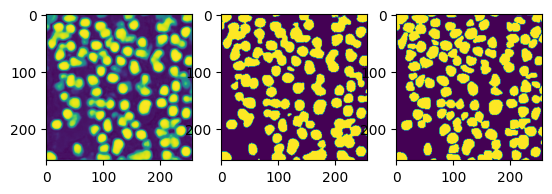

In [26]:

#选择第一个样本进行可视化
sample_idx = 0

with torch.no_grad():  #
    preds_logits = model(x_batch_tensor)
    preds_probs = torch.sigmoid(preds_logits)
pred_probs_np = preds_probs[sample_idx, 0].cpu().numpy()  
pred_mask_np = (pred_probs_np > 0.5).astype(float)
target_np = targets_batch_tensor[sample_idx, 0].cpu().numpy()

plt.subplot(1,3,1)
plt.imshow(pred_probs_np)
plt.subplot(1,3,2)
plt.imshow(pred_mask_np)
plt.subplot(1,3,3)
plt.imshow(target_np,)
plt.show()

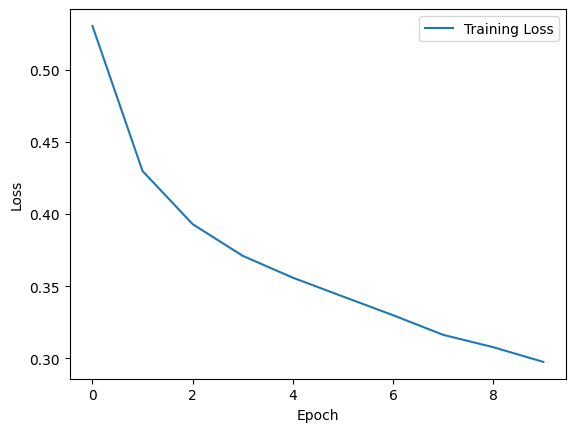

In [27]:
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 练习：完成模型测试部分

In [28]:
model_path = "./model.pt" 
test_model = torch.load(model_path, map_location=torch.device('cpu'),weights_only=False) 
test_model.to(device) 
test_model.eval() 

x_test_tensor = torch.from_numpy(x_test_patch).float()
y_test_tensor = torch.from_numpy(y_test_patch).float()
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=Batch_size, shuffle=False) 
test_loss_criterion = nn.BCEWithLogitsLoss() 
total_test_loss = 0.0


all_test_ious = []
with torch.no_grad(): 
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            outputs_logits = test_model(x_batch)
            
            
            loss = test_loss_criterion(outputs_logits, y_batch)
            total_test_loss += loss.item() * x_batch.size(0) 

            outputs_probs = torch.sigmoid(outputs_logits)

            for j in range(outputs_probs.shape[0]):
                pred_sample = outputs_probs[j]
                target_sample = y_batch[j]
                iou_val = iou(pred_sample, target_sample) 
                all_test_ious.append(iou_val.cpu().item())
ious_test=np.array(all_test_ious)
print(ious_test)
print(np.mean(ious_test))
            
          

                


[0.73531967 0.72139794 0.55057037 0.73618162 0.72388136 0.68728143
 0.68745863 0.66823894 0.71971744 0.56886321 0.67424101 0.62676549
 0.63362253 0.60094571 0.60586452 0.44660613 0.57214212 0.58524144
 0.61702502 0.47664115 0.55039167 0.44308838 0.5292955  0.46954003
 0.55664128 0.56506616 0.59908766 0.5928598  0.65939367 0.52467
 0.63585055 0.55957812 0.70690209 0.52006185 0.68704432 0.67507076
 0.71230245 0.73382676 0.61067653 0.6351043  0.65255439 0.68672514
 0.65096152 0.61400157 0.69892126 0.75632596 0.75729948 0.73484576
 0.71025699 0.72922832 0.71327978 0.77695298 0.733513   0.76374918
 0.70779383 0.66737205 0.69655043 0.6601631  0.70853817 0.73815203
 0.76603746 0.65394557 0.68263942 0.58755517 0.64772862 0.61829913
 0.65569001 0.70906597 0.57014692 0.63306785 0.5708825  0.55626947
 0.69843102 0.62404752 0.65710211 0.58431309 0.64242196 0.63405561
 0.61535907 0.58963811 0.7022078  0.30948135 0.61240613 0.76704687
 0.73021102 0.64503521 0.72742021 0.58570099 0.60318732 0.7285265

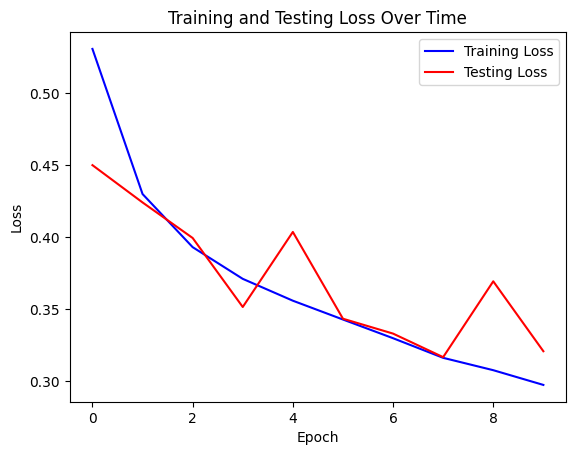

In [30]:
plt.plot(range(epochs), train_losses, label="Training Loss", color='blue')
plt.plot(range(epochs), test_losses, label="Testing Loss", color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Testing Loss Over Time")
plt.legend()
plt.show()

增加enpoch数应该可以使之更平滑